# InSAR denoiser testing

In [1]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from PIL import Image
import rioxarray
import xarray as xr
import rasterio as rio

## define network and load model

In [2]:
class DnCNN(nn.Module):
    """
    Neural network model for InSAR denoising adapted from Rouet-Leduc et al., 2021
    """
    def __init__(self):
        super().__init__()
        kernel_size=3
        padding=1
        features=64
        channels=2
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 4
        self.cnn4 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 5
        self.cnn5 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=5, dilation=5)
        
        # Convolution 6
        self.cnn6 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=5, dilation=5)
        
        # Convolution 7
        self.cnn7 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 8
        self.cnn8 = nn.Conv2d(in_channels=features, out_channels=1, kernel_size=kernel_size, padding=padding)

    def forward(self, x, dem):                
        # Set 1
        out = F.elu(self.cnn1(torch.cat((x, dem), dim=1)), inplace=True) 
        
        # Set 2
        out = F.elu(self.cnn2(out), inplace=True) 
        
        # Set 3
        out = F.elu(self.cnn3(out), inplace=True)  
        
        # Set 4
        out = F.elu(self.cnn4(out), inplace=True) 
        
        # Set 5
        out = F.elu(self.cnn5(out), inplace=True) 
        
        # Set 6
        out = F.elu(self.cnn6(out), inplace=True)
        
        # Set 7
        out = F.elu(self.cnn7(out), inplace=True) 
        
        # Set 8
        out = self.cnn8(out)
        
        return out

In [3]:
class DnCNN_signal(nn.Module):
    """
    Neural network model for InSAR denoising adapted from Rouet-Leduc et al., 2021
    """
    def __init__(self):
        super().__init__()
        kernel_size=3
        padding=1
        features=64
        channels=2
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 3
        self.cnn3 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 4
        self.cnn4 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 5
        self.cnn5 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=1, dilation=1)
        
        # Convolution 6
        self.cnn6 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=2, dilation=2)
        
        # Convolution 7
        self.cnn7 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=3, dilation=3)
        
        # Convolution 8
        self.cnn8 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=4, dilation=4)
        
        # Convolution 9
        self.cnn9 = nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=5, dilation=5)
        
        # Convolution 10
        self.cnn10 = nn.Conv2d(in_channels=384, out_channels=192, kernel_size=kernel_size, padding=padding)
        
        # Convolution 11
        self.cnn11 = nn.Conv2d(in_channels=192, out_channels=features, kernel_size=kernel_size, padding=padding)
        
        # Convolution 12
        self.cnn12 = nn.Conv2d(in_channels=features, out_channels=1, kernel_size=kernel_size, padding=padding)

    def forward(self, x, dem):                
        # Set 1
        out = F.elu(self.cnn1(torch.cat((x, dem), dim=1)), inplace=True) 
        
        # Set 2
        out = F.elu(self.cnn2(out), inplace=True) 
        
        # Set 3
        out = F.elu(self.cnn3(out), inplace=True)  
        
        # Set 4
        out = F.elu(self.cnn4(out), inplace=True) 
        
        # Set 5
        out_d5 = F.elu(self.cnn5(out), inplace=True)
        
        # Set 6
        out_d4 = F.elu(self.cnn6(out), inplace=True)
        
        # Set 7
        out_d3 = F.elu(self.cnn7(out), inplace=True)
        
        # Set 8
        out_d2 = F.elu(self.cnn8(out), inplace=True)
        
        # Set 9
        out_d1 = F.elu(self.cnn9(out), inplace=True)
        
        # Set 10
        out = F.elu(self.cnn10(torch.cat((out_d5, out_d4, out_d3, out_d2, out_d1, out), dim=1)), inplace=True)
        
        # Set 11
        out = F.elu(self.cnn11(out), inplace=True)
        
        # Set 9
        out = self.cnn12(out)
        
        return out

In [28]:
# load noise model
noise_model = DnCNN()
noise_model.load_state_dict(torch.load('/Users/qbren/Desktop/taco/projects/atmospheric_correction/InSAR_denoising_CNN/model_200_epochs'))

<All keys matched successfully>

In [5]:
# load signal model
signal_model = DnCNN_signal()
signal_model.load_state_dict(torch.load('/Users/qbren/Desktop/taco/projects/atmospheric_correction/InSAR_denoising_CNN/signal_modelv0_200_epochs'))

<All keys matched successfully>

# Load tifs

In [6]:
# functions to load interferogram tifs to xarray

def xr_read_geotif(geotif_file_path, masked=True):
    """
    Reads in single or multi-band GeoTIFF as dask array.
    Inputs
    ----------
    GeoTIFF_file_path : GeoTIFF file path
    Returns
    -------
    ds : xarray.Dataset
        Includes rioxarray extension to xarray.Dataset
    """

    da = rioxarray.open_rasterio(geotif_file_path, masked=True)

    # Extract bands and assign as variables in xr.Dataset()
    ds = xr.Dataset()
    for i, v in enumerate(da.band):
        da_tmp = da.sel(band=v)
        da_tmp.name = "band" + str(i + 1)

        ds[da_tmp.name] = da_tmp

    # Delete empty band coordinates.
    # Need to preserve spatial_ref coordinate, even though it appears empty.
    # See spatial_ref attributes under ds.coords.variables used by rioxarray extension.
    del ds.coords["band"]

    # Preserve top-level attributes and extract single value from value iterables e.g. (1,) --> 1
    ds.attrs = da.attrs
    for key, value in ds.attrs.items():
        try:
            if len(value) == 1:
                ds.attrs[key] = value[0]
        except TypeError:
            pass

    return ds


def hyp3_to_xarray(hyp3_dir, file_type='unw_phase', interpolate_na=True):
    
    dirs = os.listdir(hyp3_dir) #list generated interferograms
    datasets = []
    
    for idir in dirs:
        cwd = f'{hyp3_dir}/{idir}'
        os.chdir(cwd) #change to interferogram dir

        ext = f'{file_type}.tif' #end of filename for desired hyp3 product
        
        for fn in os.listdir(cwd): #select appropriate hyp3 product
            if fn[-len(ext):] == ext: 
                tif_fn = fn
        tif_path = f'{hyp3_dir}/{idir}/{tif_fn}'
        dates = f'{tif_fn[5:13]}_{tif_fn[21:29]}' #parse filename for interferogram dates
        
        src = xr_read_geotif(tif_path, masked=False) #read product to xarray ds
        src = src.assign_coords({"dates": dates})
        src = src.expand_dims("dates")
        
        if interpolate_na == True:
            src = src.interpolate_na(dim='x', method='linear').fillna(value=0)# need to interpolate na before passing NN
            
        
        datasets.append(src)
       
    ds = xr.concat(datasets, dim="dates", combine_attrs="no_conflicts") #create dataset
    return ds 

In [7]:
# open ints and dems
hyp3_dir = '/Users/qbren/Desktop/taco/projects/atmospheric_correction/data_processing/test_data/asc_crop'

int_xarray = hyp3_to_xarray(hyp3_dir)

dem_fn = 'S1AA_20160708T172306_20160720T172307_VVP012_INT40_G_ueF_CA3F/S1AA_20160708T172306_20160720T172307_VVP012_INT40_G_ueF_CA3F_dem.tif'
dem_src = rio.open(f'{hyp3_dir}/{dem_fn}')
dem_np = dem_src.read(1) 

In [ ]:
# visualize arrays
#f, ax = plt.subplots(1,2,figsize=(15,7))
#ax[0].imshow(int_xarray.isel(dates=0).band1, cmap='RdBu')
#ax[0].set_title('interferogram')
#ax[1].imshow(dem_np)
#ax[1].set_title('DEM')
#plt.tight_layout()          

## Prepare for model run

In [69]:
# function to prepare arrays for model run
def arrays_to_tensor(int_array, dem_array, norm=True):
    
    test_tensor = torch.Tensor(int_array.to_numpy()[0])
    dem_tensor = torch.Tensor(dem_array)
    
    if norm==True:
        #test_tensor = 2*(((test_tensor-(test_tensor.min()))/(test_tensor.max()-(test_tensor.min()))))-1
        dem_tensor = 2*(((dem_tensor-(dem_tensor.min()))/(dem_tensor.max()-(dem_tensor.min()))))-1
    
    return test_tensor, dem_tensor


#functions to return to original values
def undo_norm(og_min, og_max, tensor):
    og_tensor = (((tensor+1)/2)*(og_max-og_min))+og_min
    
    return og_tensor

## Run noise model

In [72]:
test, dem = arrays_to_tensor(int_xarray.isel(dates=201).to_array(), dem_np, norm=True)
noise = noise_model(test[None, None, :, :], dem[None, None, :, :])

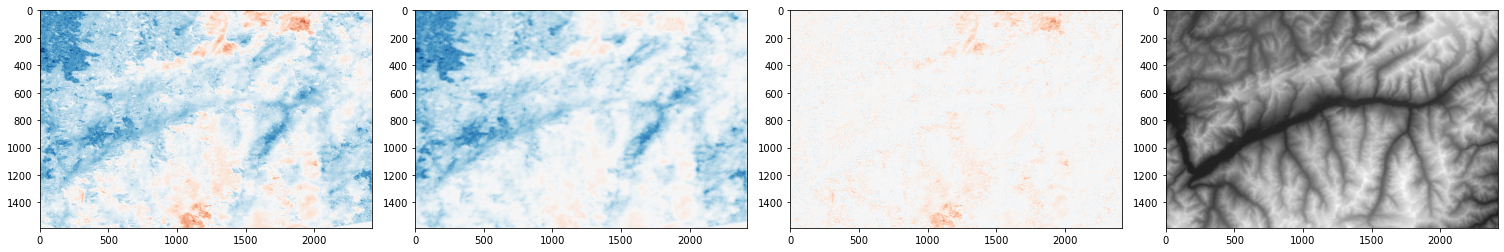

In [73]:
f, ax = plt.subplots(1, 4, figsize=(21, 10))
ax[0].imshow(test, cmap='RdBu', vmin=-20, vmax=20)
ax[1].imshow(noise.detach().squeeze(), cmap='RdBu', vmin=-20, vmax=20)
ax[2].imshow((test-noise.detach().squeeze()), cmap='RdBu', vmin=-20, vmax=20)
ax[3].imshow(dem, cmap='Greys_r')
plt.tight_layout()

In [ ]:
for i in for i in range(int_xarray.sizes['dates']):
    
    minmax_list.append([float(int_xarray.isel(dates=i).band1.min().values),
                        float(int_xarray.isel(dates=i).band1.max().values)])

    test, dem = arrays_to_tensor(int_xarray.isel(dates=i).to_array(), dem_np)
    noise = noise_model(test[None, None, :, :], dem[None, None, :, :])
    
    
    

In [ ]:
f, ax = plt.subplots(1, 4, figsize=(21, 10))
ax[0].imshow(test, cmap='RdBu', vmin=-1, vmax=1)
ax[1].imshow(signal.detach().squeeze(), cmap='RdBu', vmin=-1, vmax=1)
ax[2].imshow((test-signal.detach().squeeze()), cmap='RdBu', vmin=-1, vmax=1)
ax[3].imshow(dem, cmap='Greys_r', vmin=-1, vmax=1)
plt.tight_layout()

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(21, 10))
ax[0].imshow(test_small, cmap='RdBu', vmin=-1, vmax=1)
ax[1].imshow(signal.detach().squeeze(), cmap='RdBu', vmin=-1, vmax=1)
ax[2].imshow(dem_small, cmap='Greys_r', vmin=-1, vmax=1)
plt.tight_layout()

In [ ]:
attempt = undo_norm(og_min=-25.37455, og_max=15.040721, tensor=(test-signal.detach().squeeze()))

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(20, 15))
ax[0].imshow(int_xarray.isel(dates=1).to_array().to_numpy()[0], cmap='RdBu', vmin=-20, vmax=20)
ax[1].imshow(attempt, cmap='RdBu', vmin=-20, vmax=20)

In [ ]:
for i in range(int_xarray.sizes['dates']):
    test, dem = arrays_to_tensor(int_xarray.isel(dates=i).to_array(), dem_np)
    signal = test_model(test, dem)

In [ ]:
# run test interferograms through model